## **Import libraries**

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import Counter
from datasets import load_dataset, Dataset, DatasetDict

import string
from gensim.models import FastText

import torch
from torch import nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

batch_size = 64
model_path = "/content/drive/MyDrive/checkpoints/"

In [4]:
# Seed for reproducing
def seed_everything(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED) # For CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED) # For GPU
        torch.cuda.manual_seed_all(SEED) # For many GPUs
        torch.backends.cudnn.deterministic = True

SEED = 42
seed_everything(SEED)

## **Prepare data**

### **Load data**

- **Vietnamese students feedback** is a dataset used for both sentiment analysis and topic classification.
- In this assignment, **sentiment analysis** will be implemented.
- The **sentiment** column has 3 categories: `0 - Negative`, `1 - Neutral`, `2 - Positive`.

In [3]:
dataset = load_dataset("uitnlp/vietnamese_students_feedback")
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 11426
    })
    validation: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 1583
    })
    test: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 3166
    })
})

### **Visualize sentiment**

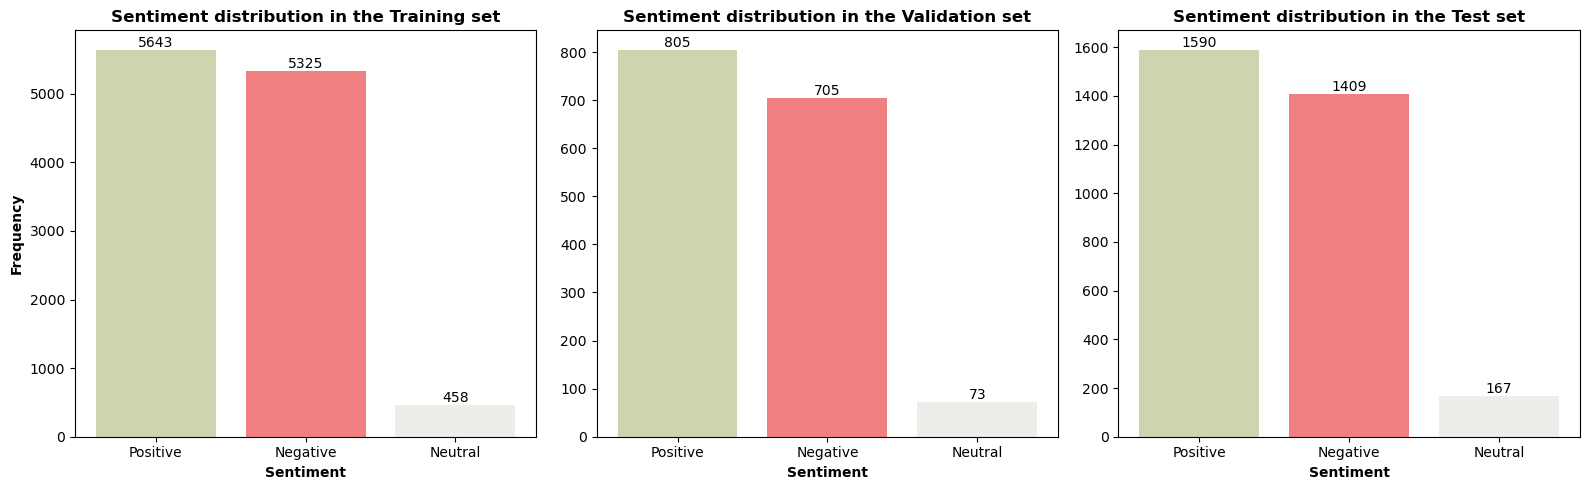

In [18]:
label_map = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
}

color_map = {
    "Negative": "#f08080",
    "Neutral": "#edede9",
    "Positive": "#ccd5ae"
}

train_df = pd.DataFrame({"sentiment": dataset["train"]["sentiment"]})
train_df["sentiment"] = train_df["sentiment"].map(label_map)

validation_df = pd.DataFrame({"sentiment": dataset["validation"]["sentiment"]})
validation_df["sentiment"] = validation_df["sentiment"].map(label_map)

test_df = pd.DataFrame({"sentiment": dataset["test"]["sentiment"]})
test_df["sentiment"] = test_df["sentiment"].map(label_map)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

dfs = [train_df, validation_df, test_df]
titles = ["Sentiment distribution in the Training set", 
          "Sentiment distribution in the Validation set", 
          "Sentiment distribution in the Test set"]

for i, ax in enumerate(axes):
    counts = dfs[i]["sentiment"].value_counts()
    colors = [color_map[sentiment] for sentiment in counts.index]
    bars = ax.bar(counts.index, counts.values, color=colors)
    
    # Add numbers on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, str(height), 
                ha="center", va="bottom", fontsize=10)
    
    ax.set_title(titles[i], fontweight="bold")
    ax.set_xlabel("Sentiment", fontweight="bold")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
axes[0].set_ylabel("Frequency", fontweight="bold")

plt.tight_layout()
plt.show()

### **Build vocabularies**

**Get distinct words**

In [7]:
def count_tokens(dataset_split: DatasetDict, col: str, counts: Counter, max_tokens: int) -> int:
    for sentence in dataset_split[col]:
        tokens = sentence.split(" ")
        counts.update(tokens)
        if len(tokens) > max_tokens:
            max_tokens = len(tokens)
    return max_tokens

# Get distinct words across train, validation and test data
counts = Counter()
max_tokens = 0 # Maximum number of tokens
max_tokens = count_tokens(dataset["train"], "sentence", counts, max_tokens)
max_tokens = count_tokens(dataset["validation"], "sentence", counts, max_tokens)
max_tokens = count_tokens(dataset["test"], "sentence", counts, max_tokens)

# Delete infrequent words
print("The number of words before:", len(counts.keys()))

for word in list(counts):
    if counts[word] < 2:
        del counts[word]

print("The number of words after:", len(counts.keys()))
print("The maximum number of tokens:", max_tokens)

The number of words before: 2878
The number of words after: 1722
The maximum number of tokens: 161


**Map each word into an index**

In [8]:
word_to_index = {"": 0, "UNK": 1}
words = ["", "UNK"]

for word in counts:
    if word != "":
        word_to_index[word] = len(words)
        words.append(word)

### **Preprocess data**

**Encode text**

In [9]:
def encode_sentence(sentence: str, word_to_index: dict, max_tokens: int) -> list:
    fixed_encoded = np.zeros(max_tokens, dtype=int)
    encoded = np.array([word_to_index.get(word, word_to_index["UNK"]) for word in sentence.split(" ")])

    # Ensure the encoded sentence reaches the maximum specified length.
    length = min(max_tokens, len(encoded))
    fixed_encoded[:length] = encoded[:length]
    return list(fixed_encoded)

train_features = dataset["train"].to_pandas()["sentence"].map(lambda sentence: encode_sentence(sentence, word_to_index, max_tokens)).to_list()
validation_features = dataset["validation"].to_pandas()["sentence"].map(lambda sentence: encode_sentence(sentence, word_to_index, max_tokens)).to_list()
test_features = dataset["test"].to_pandas()["sentence"].map(lambda sentence: encode_sentence(sentence, word_to_index, max_tokens)).to_list()

**Create Dataset**

In [10]:
# Creat datasets from features and labels
train_dataset = Dataset.from_dict({
    "sentence": train_features,
    "sentiment": dataset["train"]["sentiment"]
})

validation_dataset = Dataset.from_dict({
    "sentence": validation_features,
    "sentiment": dataset["validation"]["sentiment"]
})

test_dataset = Dataset.from_dict({
    "sentence": test_features,
    "sentiment": dataset["test"]["sentiment"]
})

**Create DataLoader**

In [11]:
def collate_fn(batch):
    sentences = torch.tensor([item["sentence"] for item in batch])  # Stack sentence tensors
    labels = torch.tensor([item["sentiment"] for item in batch])    # Stack sentiment tensors
    return {"sentence": sentences, "sentiment": labels}

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)

## **Build model**

In [12]:
class TextClassifier(nn.Module):
    def __init__(
        self,
        num_classes,
        vocab_size,
        embedding_dim,
        embedding_tensors,
        lstm_hidden_size,
        conv_in_channels,
        conv_out_channels,
        fc_in_features,
        fc_out_features
    ):
        super(TextClassifier, self).__init__()

        # Embedding layer
        if embedding_tensors is not None:
          self.embedding = nn.Embedding.from_pretrained(embedding_tensors, freeze=False).to(device)
        else:
          self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        # Dropout
        self.dropout = nn.Dropout(0.2)

        # LSTM
        self.LSTM = nn.LSTM(input_size=embedding_dim, hidden_size=lstm_hidden_size, batch_first=True)

        # CNN
        self.Conv1 = nn.Conv1d(in_channels=conv_in_channels, out_channels=conv_out_channels, kernel_size=3)
        self.Conv2 = nn.Conv1d(in_channels=conv_in_channels, out_channels=conv_out_channels, kernel_size=5)
        self.Conv3 = nn.Conv1d(in_channels=conv_in_channels, out_channels=conv_out_channels, kernel_size=7)

        # Fully connected layer
        self.fc = nn.Linear(in_features=fc_in_features, out_features=fc_out_features)

        # Output layer
        self.output = nn.Linear(in_features=fc_out_features, out_features=num_classes)

    def forward(self, x):
        embeds = self.embedding(x) # (batch_size, sequence_length, embedding_dim)
        lstm_out, _ = self.LSTM(embeds) # (batch_size, sequence_length, 128)
        lstm_out = lstm_out[:, -1, :] # Select the last time step in each batch

        embeds = embeds.permute(0, 2, 1) # (batch_size, embedding_dim, sequence_length)
        conv1_out = F.relu(self.Conv1(embeds))
        conv1_out = torch.max(conv1_out, dim=2)[0] # (batch_size, conv_out_channels)

        conv2_out = F.relu(self.Conv2(embeds))
        conv2_out = torch.max(conv2_out, dim=2)[0]

        conv3_out = F.relu(self.Conv3(embeds))
        conv3_out = torch.max(conv3_out, dim=2)[0]

        conv_concat = torch.cat((conv1_out, conv2_out, conv3_out), dim=1) # (batch_size, 3 * conv_out_channels)

        lstm_cnn_concat = torch.cat((lstm_out, conv_concat), dim=1) # (batch_size, 3 * conv_out_channels + 128)
        fc_out = self.dropout(F.relu(self.fc(lstm_cnn_concat)))
        output = self.output(fc_out)
        return output

## **Train model**

In [17]:
# Configuration
num_classes = 3
vocab_size = len(word_to_index)
embedding_dim = 200
lstm_hidden_size = 128
conv_in_channels = 200
conv_out_channels = 150
fc_in_features = 3 * conv_out_channels + lstm_hidden_size
fc_out_features = 200

epochs = 10
learning_rate = 1e-3

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

writer = SummaryWriter() # For using Tensorboard

# Create model
downstream_model = TextClassifier(
  num_classes,
  vocab_size,
  embedding_dim,
  None,
  lstm_hidden_size,
  conv_in_channels,
  conv_out_channels,
  fc_in_features,
  fc_out_features
).to(device)

# Initialize optimizer
optimizer = optim.Adam(downstream_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1, min_lr=1e-5)

# For imbalanced dataset
class_weights = compute_class_weight(class_weight="balanced", classes=np.array(np.unique(train_dataset["sentiment"]).tolist()), y=np.array(train_dataset["sentiment"]))
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define loss function
criterion = nn.CrossEntropyLoss(class_weights)

In [18]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

epoch_val_loss_min = 1

for epoch in range(epochs):
    total_train_loss = 0
    total_train_acc = 0
    total_val_loss = 0
    total_val_acc = 0
    # ==================== TRAINING PHASE ====================
    # Set model to training mode
    downstream_model.train()

    for i, data in enumerate(train_dataloader):
        train_inputs = data["sentence"].to(device)
        train_labels = data["sentiment"].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = downstream_model(train_inputs)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        predicted = torch.argmax(F.softmax(outputs, dim=1), dim=1)
        accuracy = (predicted == train_labels).sum().item()
        total_train_acc += accuracy

        total_train_loss += loss.item()

    epoch_train_loss = total_train_loss / len(train_dataloader)
    epoch_train_acc = total_train_acc / len(train_dataloader)

    writer.add_scalar("loss/train", epoch_train_loss, epoch)
    writer.add_scalar("acc/train", epoch_train_acc, epoch)

    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)

    # ==================== VALIDATION PHASE ====================
    # Set model to evaluation mode
    downstream_model.eval()

    with torch.no_grad(): # Disable gradient tracking
        for i, data in enumerate(validation_dataloader):
            validation_inputs = data["sentence"].to(device)
            validation_labels = data["sentiment"].to(device)

            outputs = downstream_model(validation_inputs)
            loss = criterion(outputs, validation_labels)

            # Calculate validation accuracy
            predicted = torch.argmax(F.softmax(outputs, dim=1), dim=1)
            accuracy = (predicted == validation_labels).sum().item()
            total_val_acc += accuracy

            total_val_loss += loss.item()

    epoch_val_loss = total_val_loss / len(validation_dataloader)
    epoch_val_acc = total_val_acc / len(validation_dataloader)

    writer.add_scalar("loss/val", epoch_val_loss, epoch)
    writer.add_scalar("acc/val", epoch_val_acc, epoch)

    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

    # ======================= STATISTICS ==========================
    print("Epoch - {} lr: {}".format(epoch, optimizer.param_groups[0]["lr"]))
    print(f"\tTrain Accuracy: {epoch_train_acc:.3f}\tTrain Loss: {epoch_train_loss:.3f}\t|\tValid Accuracy: {epoch_val_acc:.3f}\tValid Loss: {epoch_val_loss:.3f}")

    # Save model if the validation loss < the minimum validation loss
    if epoch_val_loss < epoch_val_loss_min:
        epoch_val_loss_min = epoch_val_loss
        checkpoint = {
            "model": downstream_model,
            "state_dict": downstream_model.state_dict(),
            "optimizer" : optimizer.state_dict()
        }
        torch.save(checkpoint, os.path.join(model_path, "checkpoint_{}.pth".format(round(epoch_val_loss, 3))))

    # After each epoch, update the learning rate
    scheduler.step(epoch_val_loss)

writer.flush()
writer.close()

Epoch - 0 lr: 0.001
	Train Accuracy: 47.503	Train Loss: 0.671	|	Valid Accuracy: 55.040	Valid Loss: 0.507
Epoch - 1 lr: 0.001
	Train Accuracy: 55.061	Train Loss: 0.402	|	Valid Accuracy: 51.800	Valid Loss: 0.452
Epoch - 2 lr: 0.001
	Train Accuracy: 58.983	Train Loss: 0.209	|	Valid Accuracy: 55.600	Valid Loss: 0.607
Epoch - 3 lr: 0.001
	Train Accuracy: 61.006	Train Loss: 0.123	|	Valid Accuracy: 56.640	Valid Loss: 0.946
Epoch - 4 lr: 0.0005
	Train Accuracy: 62.978	Train Loss: 0.043	|	Valid Accuracy: 57.080	Valid Loss: 1.031
Epoch - 5 lr: 0.0005
	Train Accuracy: 63.497	Train Loss: 0.018	|	Valid Accuracy: 57.320	Valid Loss: 1.091
Epoch - 6 lr: 0.00025
	Train Accuracy: 63.665	Train Loss: 0.011	|	Valid Accuracy: 57.280	Valid Loss: 1.208
Epoch - 7 lr: 0.00025
	Train Accuracy: 63.682	Train Loss: 0.008	|	Valid Accuracy: 57.240	Valid Loss: 1.252
Epoch - 8 lr: 0.000125
	Train Accuracy: 63.732	Train Loss: 0.006	|	Valid Accuracy: 57.520	Valid Loss: 1.306
Epoch - 9 lr: 0.000125
	Train Accuracy: 63.732

## **Evaluate on Test set**

### **Predict labels for the Test set**

In [19]:
# Load the checkpoint with the minimum validation loss
checkpoint = torch.load(
  os.path.join(
    model_path,
    sorted([f for f in os.listdir(model_path) if os.path.isfile(os.path.join(model_path, f))])[0]
  ),
  weights_only=False
)

# Load the model
model_loaded = checkpoint["model"]

# Set the model to evaluation mode
model_loaded.eval()

# Get the predicted label of each sample in the Test set
predicted_list = []
for i in range(len(test_dataset) // batch_size):
    inputs = torch.tensor(test_dataset[(i * batch_size):((i + 1) * batch_size)]["sentence"]).to(device)
    logits = model_loaded(inputs)
    predicted = torch.argmax(torch.softmax(logits, dim=1), dim=1)
    predicted_list.extend(predicted.tolist())

true_list = test_dataset[:len(predicted_list)]["sentiment"]

### **Print the result**

In [20]:
print(classification_report(predicted_list, true_list))
print(f"Precision: ", np.round(precision_score(true_list, predicted_list, average="weighted"), 2))
print(f"Recall: ", np.round(recall_score(true_list, predicted_list, average="weighted"), 2))
print(f"F1-score: ", np.round(f1_score(true_list, predicted_list, average="weighted"), 2))
print(f"Accuracy: ", np.round(accuracy_score(true_list, predicted_list), 2))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1165
           1       0.73      0.21      0.33       558
           2       0.84      0.94      0.89      1413

    accuracy                           0.80      3136
   macro avg       0.78      0.69      0.69      3136
weighted avg       0.80      0.80      0.77      3136

Precision:  0.89
Recall:  0.8
F1-score:  0.84
Accuracy:  0.8


### **Print some samples**

In [21]:
label_map = {
    "0": "Negative",
    "1": "Neutral",
    "2": "Positive"
}

n_samples = 3

for i in range(n_samples):
    sentence = dataset["test"][i]["sentence"]
    predicted_label = predicted_list[i]
    true_label = true_list[i]

    print("Sentence: ", sentence)
    print("True Label: ", label_map[f"{true_label}"])
    print("Predicted Label: ", label_map[f"{predicted_label}"])
    print("\n")

Sentence:  nói tiếng anh lưu loát .
True Label:  Positive
Predicted Label:  Neutral


Sentence:  giáo viên rất vui tính .
True Label:  Positive
Predicted Label:  Positive


Sentence:  cô max có tâm .
True Label:  Positive
Predicted Label:  Positive




# **Experiment with FastText**

## **Train FastText**

**Tokenize sentences**

In [22]:
def tokenize_sentence(sentence: str) -> list:
  sent_no_punct = sentence.translate(str.maketrans('', '', string.punctuation)) # Remove punctuations
  tokens = sent_no_punct.lower().split() # Lowercase & Tokenize sentences
  return tokens

train_sentences = dataset["train"].to_pandas()["sentence"].to_list()
tokens_list = []
for sentence in train_sentences:
  tokens = tokenize_sentence(sentence)
  tokens_list.append(tokens)

**Train FastText using train data**

In [21]:
# Train model
model = FastText(
  tokens_list,               # List of tokenized sentences
  vector_size=200,           # Dimensionality of embeddings
  window=5,                  # Context window size
  min_count=2,               # Ignores words with total freq < 2
  workers=4,                 # Parallel training threads
  sg=1                       # 1 = Skip-gram, 0 = CBOW
)

# Save model
model.save("/content/drive/MyDrive/models/fasttext.model")

## **Preprocess data**

**Encode text:**
- Map each word in a sentence into a unique index.
- Pad with zero to fill the remaining space.

In [23]:
def encode_sentence(sentence: str, word_to_index: dict, max_tokens: int) -> list:
    fixed_encoded = np.zeros(max_tokens, dtype=int)
    encoded = np.array([word_to_index.get(word, len(word_to_index)) for word in sentence.split(" ")])

    # Ensure the encoded sentence reaches the maximum specified length.
    length = min(max_tokens, len(encoded))
    fixed_encoded[:length] = encoded[:length]
    return list(fixed_encoded)

# Load model
fasttext = FastText.load("/content/drive/MyDrive/models/fasttext.model")

max_tokens = 200
word_to_index = fasttext.wv.key_to_index
train_features = dataset["train"].to_pandas()["sentence"].map(lambda sentence: encode_sentence(sentence, word_to_index, max_tokens)).to_list()
validation_features = dataset["validation"].to_pandas()["sentence"].map(lambda sentence: encode_sentence(sentence, word_to_index, max_tokens)).to_list()
test_features = dataset["test"].to_pandas()["sentence"].map(lambda sentence: encode_sentence(sentence, word_to_index, max_tokens)).to_list()

**Create Dataset**

In [24]:
# Creat datasets from features and labels
train_dataset = Dataset.from_dict({
  "sentence": train_features,
  "sentiment": dataset["train"]["sentiment"]
})

validation_dataset = Dataset.from_dict({
  "sentence": validation_features,
  "sentiment": dataset["validation"]["sentiment"]
})

test_dataset = Dataset.from_dict({
  "sentence": test_features,
  "sentiment": dataset["test"]["sentiment"]
})

**Create DataLoader**

In [25]:
def collate_fn(batch):
    sentences = torch.tensor([item["sentence"] for item in batch])  # Stack sentence tensors
    labels = torch.tensor([item["sentiment"] for item in batch])    # Stack sentiment tensors
    return {"sentence": sentences, "sentiment": labels}

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)

## **Train sentiment model**

**Get pretrained weights for Embedding class**

In [26]:
# Get vocabularies & embeddings from the trained model
vocabs = list(fasttext.wv.index_to_key)
vocab_size = len(vocabs) + 1 # Add 1 to represent unknown words
embedding_dim = fasttext.vector_size

# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for i, word in enumerate(vocabs):
  embedding_matrix[i] = fasttext.wv[word]

# Convert to Pytorch tensor
embedding_tensors = torch.tensor(embedding_matrix, dtype=torch.float32)

**Train model**

In [27]:
# Configuration
num_classes = 3
lstm_hidden_size = 128
conv_in_channels = 200
conv_out_channels = 150
fc_in_features = 3 * conv_out_channels + lstm_hidden_size
fc_out_features = 200

epochs = 10
learning_rate = 1e-3

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

writer = SummaryWriter() # For using Tensorboard

# Create model
downstream_model = TextClassifier(
    num_classes,
    vocab_size,
    embedding_dim,
    embedding_tensors,
    lstm_hidden_size,
    conv_in_channels,
    conv_out_channels,
    fc_in_features,
    fc_out_features
).to(device)

# Initialize optimizer
optimizer = optim.Adam(downstream_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1, min_lr=1e-5)

# For imbalanced dataset
class_weights = compute_class_weight(class_weight="balanced", classes=np.array(np.unique(train_dataset["sentiment"]).tolist()), y=np.array(train_dataset["sentiment"]))
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define loss function
criterion = nn.CrossEntropyLoss(class_weights)

In [28]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

epoch_val_loss_min = 1

for epoch in range(epochs):
    total_train_loss = 0
    total_train_acc = 0
    total_val_loss = 0
    total_val_acc = 0
    # ==================== TRAINING PHASE ====================
    # Set model to training mode
    downstream_model.train()

    for i, data in enumerate(train_dataloader):
        train_inputs = data["sentence"].to(device)
        train_labels = data["sentiment"].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = downstream_model(train_inputs)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        predicted = torch.argmax(F.softmax(outputs, dim=1), dim=1)
        accuracy = (predicted == train_labels).sum().item()
        total_train_acc += accuracy

        total_train_loss += loss.item()

    epoch_train_loss = total_train_loss / len(train_dataloader)
    epoch_train_acc = total_train_acc / len(train_dataloader)

    writer.add_scalar("loss/train", epoch_train_loss, epoch)
    writer.add_scalar("acc/train", epoch_train_acc, epoch)

    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)

    # ==================== VALIDATION PHASE ====================
    # Set model to evaluation mode
    downstream_model.eval()

    with torch.no_grad(): # Disable gradient tracking
        for i, data in enumerate(validation_dataloader):
            validation_inputs = data["sentence"].to(device)
            validation_labels = data["sentiment"].to(device)

            outputs = downstream_model(validation_inputs)
            loss = criterion(outputs, validation_labels)

            # Calculate validation accuracy
            predicted = torch.argmax(F.softmax(outputs, dim=1), dim=1)
            accuracy = (predicted == validation_labels).sum().item()
            total_val_acc += accuracy

            total_val_loss += loss.item()

    epoch_val_loss = total_val_loss / len(validation_dataloader)
    epoch_val_acc = total_val_acc / len(validation_dataloader)

    writer.add_scalar("loss/val", epoch_val_loss, epoch)
    writer.add_scalar("acc/val", epoch_val_acc, epoch)

    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

    # ======================= STATISTICS ==========================
    print("Epoch - {} lr: {}".format(epoch, optimizer.param_groups[0]["lr"]))
    print(f"\tTrain Accuracy: {epoch_train_acc:.3f}\tTrain Loss: {epoch_train_loss:.3f}\t|\tValid Accuracy: {epoch_val_acc:.3f}\tValid Loss: {epoch_val_loss:.3f}")

    # Save model if the validation loss < the minimum validation loss
    if epoch_val_loss < epoch_val_loss_min:
        epoch_val_loss_min = epoch_val_loss
        checkpoint = {
            "model": downstream_model,
            "state_dict": downstream_model.state_dict(),
            "optimizer" : optimizer.state_dict()
        }
        torch.save(checkpoint, os.path.join(model_path, "checkpoint_{}.pth".format(round(epoch_val_loss, 3))))

    # After each epoch, update the learning rate
    scheduler.step(epoch_val_loss)

writer.flush()
writer.close()

Epoch - 0 lr: 0.001
	Train Accuracy: 49.201	Train Loss: 0.611	|	Valid Accuracy: 55.960	Valid Loss: 0.447
Epoch - 1 lr: 0.001
	Train Accuracy: 55.318	Train Loss: 0.390	|	Valid Accuracy: 56.400	Valid Loss: 0.412
Epoch - 2 lr: 0.001
	Train Accuracy: 57.547	Train Loss: 0.287	|	Valid Accuracy: 57.480	Valid Loss: 0.474
Epoch - 3 lr: 0.001
	Train Accuracy: 59.011	Train Loss: 0.214	|	Valid Accuracy: 57.480	Valid Loss: 0.609
Epoch - 4 lr: 0.0005
	Train Accuracy: 60.698	Train Loss: 0.134	|	Valid Accuracy: 57.080	Valid Loss: 0.616
Epoch - 5 lr: 0.0005
	Train Accuracy: 61.615	Train Loss: 0.098	|	Valid Accuracy: 57.720	Valid Loss: 0.752
Epoch - 6 lr: 0.00025
	Train Accuracy: 62.313	Train Loss: 0.069	|	Valid Accuracy: 58.280	Valid Loss: 0.941
Epoch - 7 lr: 0.00025
	Train Accuracy: 62.620	Train Loss: 0.057	|	Valid Accuracy: 58.320	Valid Loss: 1.038
Epoch - 8 lr: 0.000125
	Train Accuracy: 62.950	Train Loss: 0.044	|	Valid Accuracy: 58.280	Valid Loss: 1.021
Epoch - 9 lr: 0.000125
	Train Accuracy: 62.972

## **Evaluate on Test set**

In [29]:
# Load the checkpoint with the minimum validation loss
checkpoint = torch.load(
  os.path.join(
    model_path,
    sorted([f for f in os.listdir(model_path) if os.path.isfile(os.path.join(model_path, f))])[0]
  ),
  weights_only=False
)

# Load the model
model_loaded = checkpoint["model"]

# Set the model to evaluation mode
model_loaded.eval()

# Get the predicted label of each sample in the Test set
predicted_list = []
for i in range(len(test_dataset) // batch_size):
    inputs = torch.tensor(test_dataset[(i * batch_size):((i + 1) * batch_size)]["sentence"]).to(device)
    logits = model_loaded(inputs)
    predicted = torch.argmax(torch.softmax(logits, dim=1), dim=1)
    predicted_list.extend(predicted.tolist())

true_list = test_dataset[:len(predicted_list)]["sentiment"]

In [30]:
print(classification_report(predicted_list, true_list))
print(f"Precision: ", np.round(precision_score(true_list, predicted_list, average="weighted"), 2))
print(f"Recall: ", np.round(recall_score(true_list, predicted_list, average="weighted"), 2))
print(f"F1-score: ", np.round(f1_score(true_list, predicted_list, average="weighted"), 2))
print(f"Accuracy: ", np.round(accuracy_score(true_list, predicted_list), 2))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1400
           1       0.58      0.31      0.41       304
           2       0.87      0.95      0.91      1432

    accuracy                           0.87      3136
   macro avg       0.78      0.72      0.74      3136
weighted avg       0.85      0.87      0.85      3136

Precision:  0.89
Recall:  0.87
F1-score:  0.88
Accuracy:  0.87
